In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df

,fen_value,score
332449,6r1/p2nkp1p/2p1b3/3p4/1Q1qn3/8/P4PPP/1R3RK1 b ...,609
117743,r2qkb1r/p1p1p1pp/2p5/3p2B1/3Pn3/5b2/PPP2PPP/RN...,-395
11856,4k2r/pp3ppp/4p3/2P1P3/2bR4/2P5/2K1q3/8 w k - 4 39,-781
34239,r4r1k/p1p1qBp1/Q1bb1n1p/8/3pP3/8/PP1N1PPP/R1B2...,187
285686,1rq1k2r/p1pbnppp/B3pn2/8/3P4/Q1P1P3/P4PPP/R1B1...,-208
...,...,...
189928,rn1q1rk1/ppp1bppp/5n2/3pp3/8/1P4PN/P1PPPP1P/RN...,128
138019,8/p1kr1ppp/1p6/2P5/7n/P3rP2/2P4P/3R3K w - - 0 28,-656
20642,8/8/6p1/8/5k2/8/2r5/6K1 b - - 17 61,8496
291292,4r3/7p/R7/1p1R1b2/5PkP/6P1/PPr5/1K6 b - - 1 27,8498


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [7]:
X.shape, y.shape

(torch.Size([30000, 70]), torch.Size([30000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.bfloat16)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.1
num_steps = 3000
warmup_steps = 250
bs = len(X)
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [13]:
from torch.optim.lr_scheduler import LambdaLR


In [14]:
model = MLPEngine(embedding_dim=64).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr = lr)
# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.95 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model = model.to(torch.bfloat16)
model.compile()

In [15]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [16]:
train_history = {}
val_history = {}
start_step = 0

In [26]:
model.train()
# train_history = {}
# val_history = {}
for step_i in range(num_steps):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # print(f"Epoch {step_i}, Learning Rate: {scheduler.get_last_lr()}")
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[tot_step] = loss.item()

start_step += num_steps

3000 :  11072.0
3001 :  10752.0
3002 :  10944.0
3003 :  11136.0
3004 :  10944.0
3005 :  11264.0
3006 :  11008.0
3007 :  11008.0
3008 :  10624.0
3009 :  11200.0
3010 :  11328.0
3011 :  11328.0
3012 :  10816.0
3013 :  10880.0
3014 :  10944.0
3015 :  10752.0
3016 :  11136.0
3017 :  10880.0
3018 :  11072.0
3019 :  11008.0
3020 :  11008.0
3021 :  11200.0
3022 :  10816.0
3023 :  10752.0
3024 :  10624.0
3025 :  11200.0
3026 :  11008.0
3027 :  11264.0
3028 :  10688.0
3029 :  11136.0
3030 :  11776.0
3031 :  10816.0
3032 :  11072.0
3033 :  11200.0
3034 :  10688.0
3035 :  11456.0
3036 :  10816.0
3037 :  10688.0
3038 :  10944.0
3039 :  11520.0
3040 :  11328.0
3041 :  11456.0
3042 :  10944.0
3043 :  10880.0
3044 :  11264.0
3045 :  11008.0
3046 :  10752.0
3047 :  10880.0
3048 :  11008.0
3049 :  10816.0
3050 :  11328.0
3051 :  10624.0
3052 :  10880.0
3053 :  11072.0
3054 :  10880.0
3055 :  10752.0
3056 :  11072.0
3057 :  10880.0
3058 :  11264.0
3059 :  11008.0
3060 :  11200.0
3061 :  10944.0
3062 :  

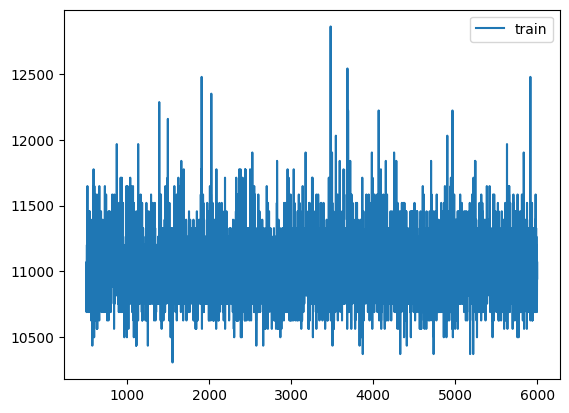

In [28]:
plt.plot(list(train_history.keys())[500:], list(train_history.values())[500:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

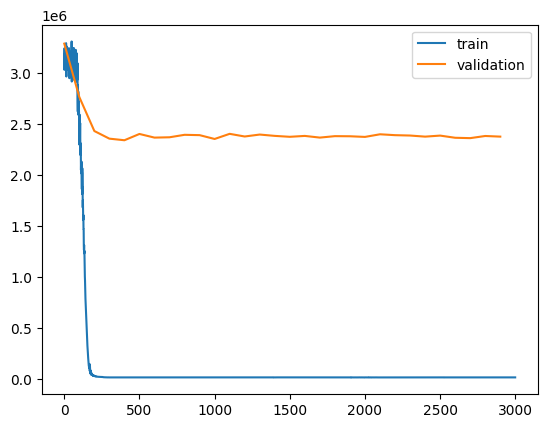

In [25]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [20]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# Inference

In [21]:
fen_sample ='rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [22]:
def get_score(fen_sample):
    # encoding
    encoder_object = ChessEncoder()
    encoded_fen = torch.tensor(encoder_object.encode_fen(fen_i), dtype=torch.int32).to(device).view(70)
    # print(encoded_fen.shape)
    bs=1
    model = MLPEngine(embedding_dim=32).to(device)
    model.eval()
    y_pred = model(encoded_fen)
    return y_pred.item()
    # run the model

In [23]:
get_score(fen_sample)

-1.1649487018585205

# TODO
- [x] do inference
- [ ] look for other/ better dataset
- [ ] add regularisation
- [x] add proper initialisation
- [ ] Then start to think about architectural changes
- [ ] do some hyperparameter tuning, maybe grid search or something
  - [x] **learning rate scheduler
  - [ ] embedding dimension changes
  - [ ] model neurons ++
  - [x] **batch/ layer normalisation
  - [ ] different precision
  - [ ] custom loss function of the specific problem
  - [ ] Check for potential gradient vanishing/exploding

current precision is giving loss as int, fix it